In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
import os
from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper
from Utils.transform import ToCategorical, cutOut


Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
def convLayer(inp,nbrLayer,channel,activation="relu"):
    assert nbrLayer > 0, "In Function convLayer nbrLayer > 0 ?"
    layer = Conv2D(channel, kernel_size=(3, 3), padding="same") (inp)
    layer = Activation(activation)(layer)
    layer = BatchNormalization()(layer)
    
    for i in range(1,nbrLayer):
        layer = Conv2D(channel, kernel_size=(3, 3), padding="same")  (layer)
        layer = Activation(activation)(layer)
        layer = BatchNormalization()(layer)
    return layer

#def FullUnetLoop(input_shape,down_channels=[64,128,256,512,1024],downLayer=2,activation="relu"):

def FullUnetLoop(input_shape,down_channels=[64,128,256,512],downLayer=2,activation="selu"):

    def zeroInflatedPoisson(output):
        rate = tf.math.softplus(output[:,:,:,0:1]) #A 
        s = tf.math.sigmoid(output[:,:,:,1:2])
        components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
         tfd.Poisson(rate=rate) #F 
         ]
        mixture = tfd.Mixture(
              cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
              components=components)
        return mixture
    
    inputs = Input(shape=input_shape)
    
    layer = Conv2D(down_channels[0], kernel_size=(3, 3), padding="same") (inputs)
    layer = Activation(activation)(layer)
    layer = BatchNormalization()(layer)
    
    layer = Conv2D(down_channels[0], kernel_size=(3, 3), padding="same") (layer)
    layer = Activation(activation)(layer)
    firstLayer = BatchNormalization()(layer)
    
    pool  = MaxPooling2D((2, 2), strides=(2, 2))(firstLayer)
    
    layerArray = []
    
    for channel in down_channels[1:]:
        
        layer = convLayer(pool,downLayer,channel)
       
        if channel != down_channels[-1]:
            layerArray.append(layer)
            pool  = MaxPooling2D((2, 2), strides=(2, 2))(layer)
            
    for i,channel in enumerate(reversed(down_channels[:-1])):
        
        layer = Conv2DTranspose(channel,(3, 3),strides=(2,2),padding="same")(layer)
        layer = Activation(activation)(layer)
        layer = BatchNormalization() (layer)
        
        if len(layerArray) >= (i+1):
            layer = concatenate([layerArray[-(i+1)], layer], axis=3)
        else:
            layer = concatenate([firstLayer, layer], axis=3)
        
        layer = convLayer(layer,downLayer,channel)
        
    output = Conv2D(1, kernel_size=(1, 1), padding="same",activation=tf.math.softplus) (layer)
    output = Flatten()(output)
    output = Dense(32*32)(output)
    output = tfp.layers.IndependentPoisson( (32,32,1) )(output)
    model = Model(inputs=inputs, outputs=output)
    return model

In [3]:
dimension = (32,32)
batch_size = 100
channels = 5
optimizer = Adam( lr = 1e-3 )
slices =[272,304,272,304]
cutOutFrame = cutOut(slices)

categorical_list = [0,1,5,10,15,30,60,120]
categorical = ToCategorical(categorical_list)

PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
TRANSFORMATIONS = [categorical]
TRANSFORMATIONS = None

def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)


def provideData(flatten=False,dimension=dimension,batch_size=60,transform=None,preTransformation=None):

    getDataSet(DatasetFolder,year=[2017],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[2017],
                            transform=transform,
                            preTransformation=preTransformation)
    
    return train,test
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

train, test = provideData(dimension=dimension,
                          batch_size=batch_size,
                          transform=TRANSFORMATIONS,
                          preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [4]:
t = Trainer(FullUnetLoop,
                    NLL,
                    (train,test),
                    batch_size = batch_size,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

print("len train,val",len(train),len(test))

[Load file failed]  ./model_data/FullUnetLoop_function/FullUnetLoop_function32x32x5.h5
[Load file failed]  ./model_data/FullUnetLoop_function/FullUnetLoop_function32x32x5history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   2944        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_norm

In [5]:
t.fit(20)

Epoch 1/20
788/788 [==============================] - 84s 106ms/step - loss: 18.7013 - mse: 0.0109 - mae: 0.0087 - val_loss: 52.7085 - val_mse: 0.0043 - val_mae: 0.0043
Epoch 2/20
788/788 [==============================] - 84s 106ms/step - loss: 12.0671 - mse: 0.0033 - mae: 0.0054 - val_loss: 15.0176 - val_mse: 0.0053 - val_mae: 0.0081
Epoch 3/20
788/788 [==============================] - 85s 108ms/step - loss: 11.6365 - mse: 0.0031 - mae: 0.0053 - val_loss: 25.7239 - val_mse: 0.0162 - val_mae: 0.0187
Epoch 4/20
788/788 [==============================] - 84s 107ms/step - loss: 11.5455 - mse: 0.0031 - mae: 0.0053 - val_loss: 15.7148 - val_mse: 0.0036 - val_mae: 0.0065
Epoch 5/20
788/788 [==============================] - 84s 107ms/step - loss: 11.4349 - mse: 0.0031 - mae: 0.0052 - val_loss: 19.4817 - val_mse: 0.0098 - val_mae: 0.0125
Epoch 6/20
788/788 [==============================] - 84s 106ms/step - loss: 11.4127 - mse: 0.0031 - mae: 0.0052 - val_loss: 14.5704 - val_mse: 0.0039 - va

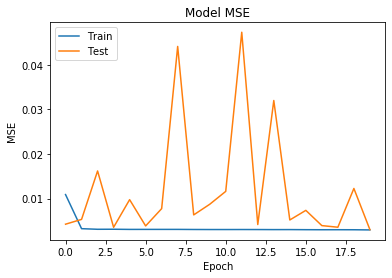

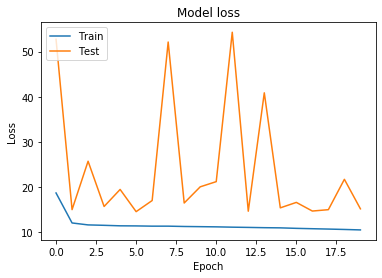

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = t.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()

In [7]:
model = t.model
pred = None
label = None
pred = 10
test.on_epoch_end()
mean = []
stdev = []
label = []
for x,y in test:
    for i in range(batch_size):
        if y[i,:,:,:].max() > 0:
            pred = model(np.array([x[i,:,:,:]]))
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
        break

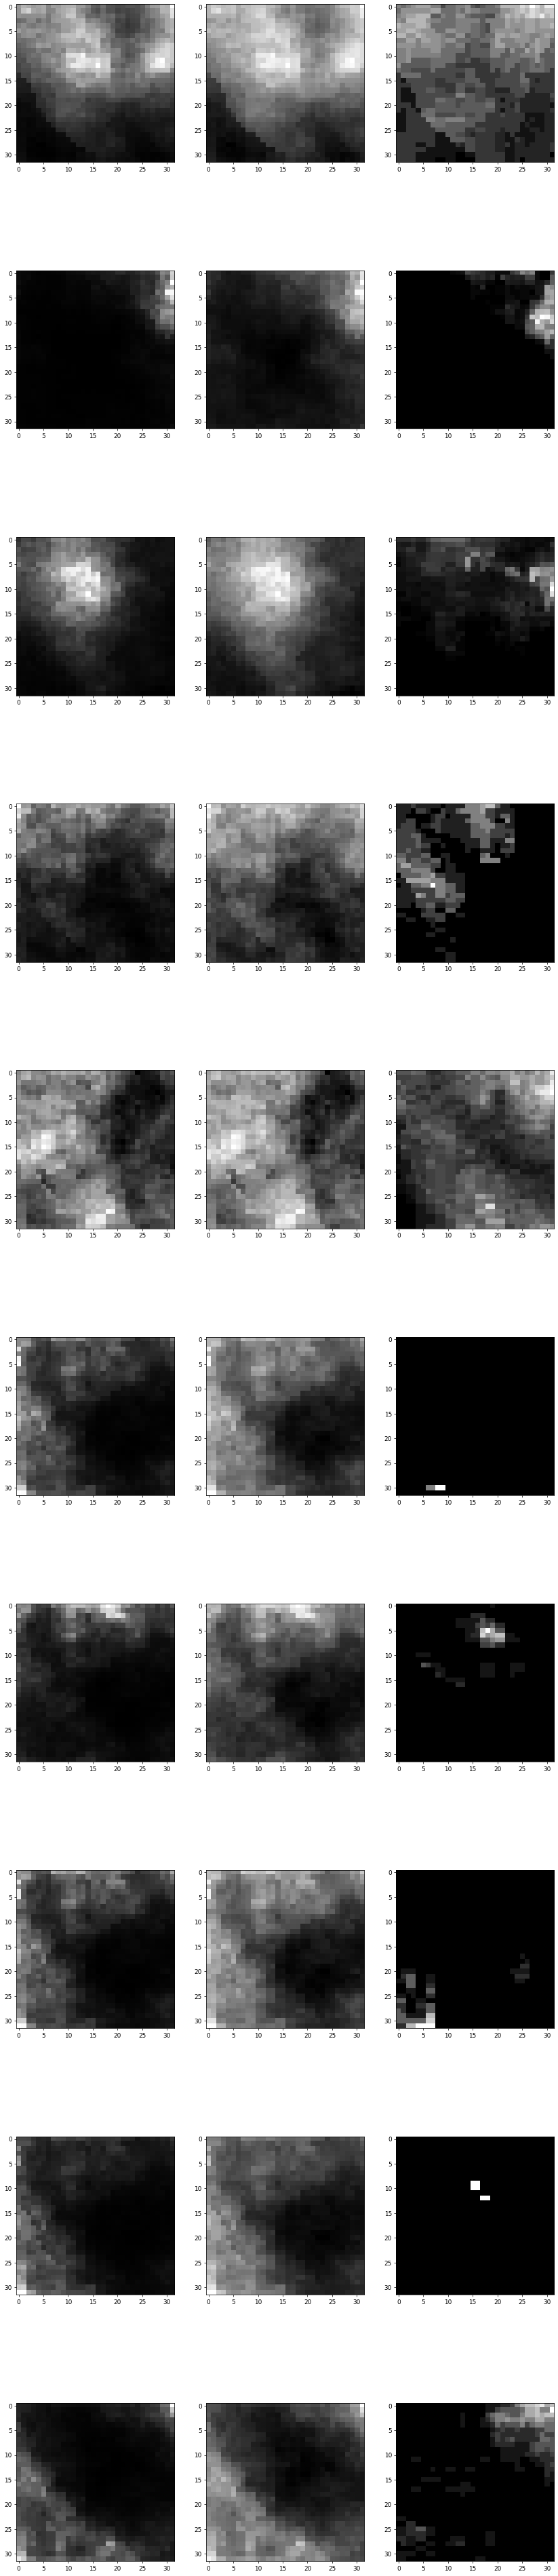

In [8]:
fig, axes = plt.subplots(10, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 10:
        break
    axes[batch,0].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,1].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")